#PROTOTYPE PENELITIAN

Nama : Mochammad Hazmi Cokro Mandiri \
NIM : 201710370311240

Deskripsi Dataset : 

Dataset berisi sekumpulan gambar retina yang diambil dengan menggunakan fotografi fundus dalam berbagai kondisi pencitraan.
Terdapat 5 kelas dengan skala 0 - 4 antara lain :

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

Total Gambar = 3662 file

# Library

In [ ]:
# *
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from google.colab import files
from google.colab import drive

# u/ Preprocessing data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

# u/ Hyperparameter Tuning
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

# u/ Melatih / Training data (Model)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation,GlobalMaxPool2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, SGD
from keras.models import load_model
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split

# u/ Evaluasi Model
import itertools
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn.metrics import  precision_recall_curve, auc, roc_curve, roc_auc_score

import warnings 
warnings.filterwarnings('ignore')

2  CPU cores


#Preprocessing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/201710370311240 - Hazmi Cokro'

/content/drive/MyDrive/201710370311240 - Hazmi Cokro


In [ ]:
def load_data():
    train = pd.read_csv('train.csv')
    train_dir = os.path.join('/content/drive/MyDrive/201710370311240 - Hazmi Cokro/[Copy] Dataset APTOS/')
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    train['diagnosis'] = train['diagnosis'].astype(str)
    return train

In [ ]:
df_train = load_data()
df_train.head(10)

,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/content/drive/MyDrive/201710370311240 - Hazmi...,000c1434d8d7.png
1,001639a390f0,4,/content/drive/MyDrive/201710370311240 - Hazmi...,001639a390f0.png
2,0024cdab0c1e,1,/content/drive/MyDrive/201710370311240 - Hazmi...,0024cdab0c1e.png
3,002c21358ce6,0,/content/drive/MyDrive/201710370311240 - Hazmi...,002c21358ce6.png
4,005b95c28852,0,/content/drive/MyDrive/201710370311240 - Hazmi...,005b95c28852.png
5,0083ee8054ee,4,/content/drive/MyDrive/201710370311240 - Hazmi...,0083ee8054ee.png
6,0097f532ac9f,0,/content/drive/MyDrive/201710370311240 - Hazmi...,0097f532ac9f.png
7,00a8624548a9,2,/content/drive/MyDrive/201710370311240 - Hazmi...,00a8624548a9.png
8,00b74780d31d,2,/content/drive/MyDrive/201710370311240 - Hazmi...,00b74780d31d.png
9,00cb6555d108,1,/content/drive/MyDrive/201710370311240 - Hazmi...,00cb6555d108.png


#Splitting Data

###[2.1] Splitting Data (Train_Test_Split)

In [ ]:
from sklearn.model_selection import train_test_split

data_train,data_test = train_test_split(df_train,test_size = 0.15)
print(data_train.shape,data_test.shape)

(3112, 4) (550, 4)


###[2.2] Show Distributed Data Train / Valid

In [ ]:
def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Paired")
    plt.title('Distribusi Data Tiap Kelas ' + str(title))
    plt.show()

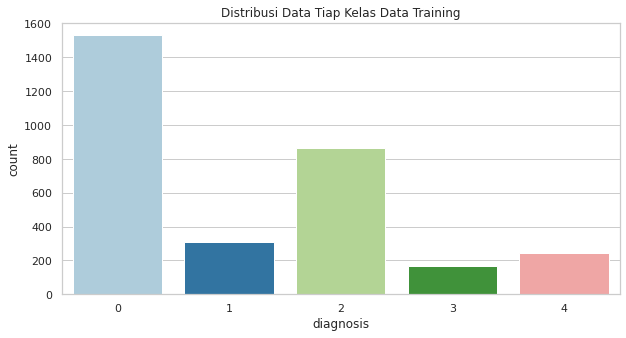

In [ ]:
plot_classes(data_train,"Data Training")

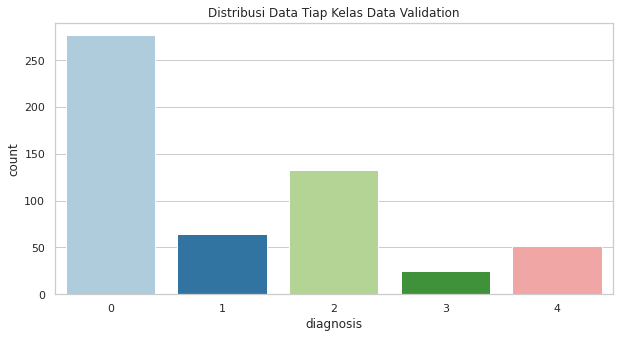

In [ ]:
plot_classes(data_valid,"Data Validation")

###[2.3] Saving Data to Pickle File

In [ ]:
# file = open('data_train', 'wb')
# pickle.dump(data_train, file)
# file.close()

# file = open('data_test', 'wb')
# pickle.dump(data_test, file)
# file.close()

In [ ]:
file = open('data_train', 'rb')
data_train = pickle.load(file)
file.close()

file = open('data_test', 'rb')
data_test = pickle.load(file)
file.close()

In [ ]:
print(data_train.shape,data_test.shape)

(3112, 4) (550, 4)


#Image Preprocessing

###[3.1] GB | Preprocessing V.Harikrishnan | 224x224

In [ ]:
!mkdir '[1.1] GB Only Training 224x224'
!mkdir '[1.2] GB Only Testing 224x224'

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

IMG_SIZE = 224

def preprocess_image1(file):
    input_filepath = os.path.join('./[Copy] Dataset APTOS/','{}.png'.format(file))
    output_filepath = os.path.join('./[1.1] GB X=10 Training 224x224/','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (224, 224))
    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , 10) ,-4 ,128)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

def preprocess_image2(file):
    input_filepath = os.path.join('./[Copy] Dataset APTOS/','{}.png'.format(file))
    output_filepath = os.path.join('./[1.1] GB X=10 Testing 224x224/','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (224, 224))
    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , 10) ,-4 ,128)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
def multiprocess_image_processor1(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image1, imgs)
    return results

def multiprocess_image_processor2(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image2, imgs)
    return results

In [ ]:
multiprocess_image_processor1(2, list(data_train.id_code.values))

In [ ]:
multiprocess_image_processor2(1, list(data_test.id_code.values))

In [ ]:
Image0 = len(os.listdir('./[1.1] GB Only Training 224x224'))
print("Total Data Image 0   : ",Image0," PNG Image")
Image1 = len(os.listdir('./[1.2] GB Only Testing 224x224'))
print("Total Data Image 0   : ",Image1," PNG Image")

Total Data Image 0   :  3112  PNG Image
Total Data Image 0   :  550  PNG Image


###[3.2] GB + CROP CIRCLE | Preprocessing Dr Graham | 224x224

In [ ]:
!mkdir '[1.1] GB Training 224x224'
!mkdir '[1.2] GB Testing 224x224'

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def circle_crop(img, sigmaX = 30):   
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

IMG_SIZE = 224

def preprocess_image1(file):
    input_filepath = os.path.join('./[Copy] Dataset APTOS/','{}.png'.format(file))
    output_filepath = os.path.join('./[2.1] GB+Crop X=30 Training 224x224/','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

def preprocess_image2(file):
    input_filepath = os.path.join('./[Copy] Dataset APTOS/','{}.png'.format(file))
    output_filepath = os.path.join('./[2.1] GB+Crop X=30 Testing 224x224/','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
def multiprocess_image_processor1(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image1, imgs)
    return results

def multiprocess_image_processor2(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image2, imgs)
    return results

In [ ]:
multiprocess_image_processor1(2, list(data_train.id_code.values))

In [ ]:
multiprocess_image_processor2(2, list(data_test.id_code.values))

In [ ]:
Image0 = len(os.listdir('/content/drive/MyDrive/201710370311240 - Hazmi Cokro/[2.1] GB+Crop X=30 Training 224x224'))
print("Total Data Image 0   : ",Image0," PNG Image")
Image1 = len(os.listdir('/content/drive/MyDrive/201710370311240 - Hazmi Cokro/[2.1] GB+Crop X=30 Testing 224x224'))
print("Total Data Image 0   : ",Image1," PNG Image")

Total Data Image 0   :  3112  PNG Image
Total Data Image 0   :  550  PNG Image


###[3.3] GB | Preprocessing Usuyama | 224x224

In [ ]:
!mkdir '[3.1] Usuyama Training 224x224'
!mkdir '[3.1] Usuyama Testing 224x224'

In [ ]:
def estimate_radius(img):
    mx = img[img.shape[0] // 2,:,:].sum(1)
    rx = (mx > mx.mean() / 10).sum() / 2
    my = img[:,img.shape[1] // 2,:].sum(1)
    ry = (my > my.mean() / 10).sum() / 2
    return (ry, rx)

def subtract_gaussian_blur(img):
    gb_img = cv2.GaussianBlur(img, (0, 0), 5)
    return cv2.addWeighted(img, 4, gb_img, -4, 128)

def remove_outer_circle(a, p, r):
    b = np.zeros(a.shape, dtype=np.uint8)
    cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(r * p), (1, 1, 1), -1, 8, 0)
    return a * b + 128 * (1 - b)

def crop_img(img, h, w):
        h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
        w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0
        crop_img = img[h_margin:h + h_margin,w_margin:w + w_margin,:]
        return crop_img

def place_in_square(img, r, h, w):
    new_img = np.zeros((2 * r, 2 * r, 3), dtype=np.uint8)
    new_img += 128
    new_img[r - h // 2:r - h // 2 + img.shape[0], r - w // 2:r - w // 2 + img.shape[1]] = img
    return new_img

scale = 112

def preprocess_image1(file):
    input_filepath = os.path.join('./[Copy] Dataset APTOS/','{}.png'.format(file))
    output_filepath = os.path.join('./[3.1] Usuyama Training 224x224/','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    ry, rx = estimate_radius(img)

    resize_scale = scale / max(rx, ry)
    w = min(int(rx * resize_scale * 2), scale * 2)
    h = min(int(ry * resize_scale * 2), scale * 2)

    img = cv2.resize(img, (0,0), fx=resize_scale, fy=resize_scale)
    
    img = crop_img(img, h, w)
    
    img = subtract_gaussian_blur(img)
    img = remove_outer_circle(img, 0.9, scale)
    img = place_in_square(img, scale, h, w)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

def preprocess_image2(file):
    input_filepath = os.path.join('./[Copy] Dataset APTOS/','{}.png'.format(file))
    output_filepath = os.path.join('./[3.1] Usuyama Testing 224x224/','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    ry, rx = estimate_radius(img)

    resize_scale = scale / max(rx, ry)
    w = min(int(rx * resize_scale * 2), scale * 2)
    h = min(int(ry * resize_scale * 2), scale * 2)

    img = cv2.resize(img, (0,0), fx=resize_scale, fy=resize_scale)
    
    img = crop_img(img, h, w)
    
    img = subtract_gaussian_blur(img)
    img = remove_outer_circle(img, 0.9, scale)
    img = place_in_square(img, scale, h, w)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
def multiprocess_image_processor1(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image1, imgs)
    return results

def multiprocess_image_processor2(process:int, imgs:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image2, imgs)
    return results

In [ ]:
multiprocess_image_processor1(2, list(data_train.id_code.values))

In [ ]:
multiprocess_image_processor2(2, list(data_test.id_code.values))

In [ ]:
Image0 = len(os.listdir('/content/drive/MyDrive/201710370311240 - Hazmi Cokro/[1.1] Usuyama Training 224x224'))
print("Total Data Image 0   : ",Image0," PNG Image")
Image1 = len(os.listdir('/content/drive/MyDrive/201710370311240 - Hazmi Cokro/[1.2] Usuyama Testing 224x224'))
print("Total Data Image 0   : ",Image1," PNG Image")

Total Data Image 0   :  3112  PNG Image
Total Data Image 0   :  550  PNG Image


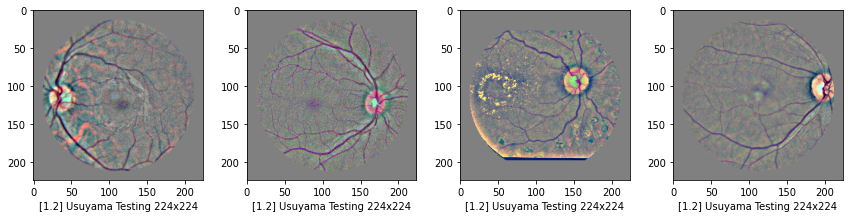

In [ ]:
listfig = '/content/drive/MyDrive/201710370311240 - Hazmi Cokro/[1.2] Usuyama Testing 224x224/'

list1 = [listfig]

fig = plt.figure(figsize=(12, 8))

j=1
for i in list1: 
    for k in range(4):
        filenames  = os.listdir(i)
        sample = random.choice(filenames)
        image = load_img(i+sample)
        plt.subplot(2,4,j)
        plt.imshow(image)
        plt.xlabel(i.split("/")[-2])
        j+=1
plt.tight_layout()